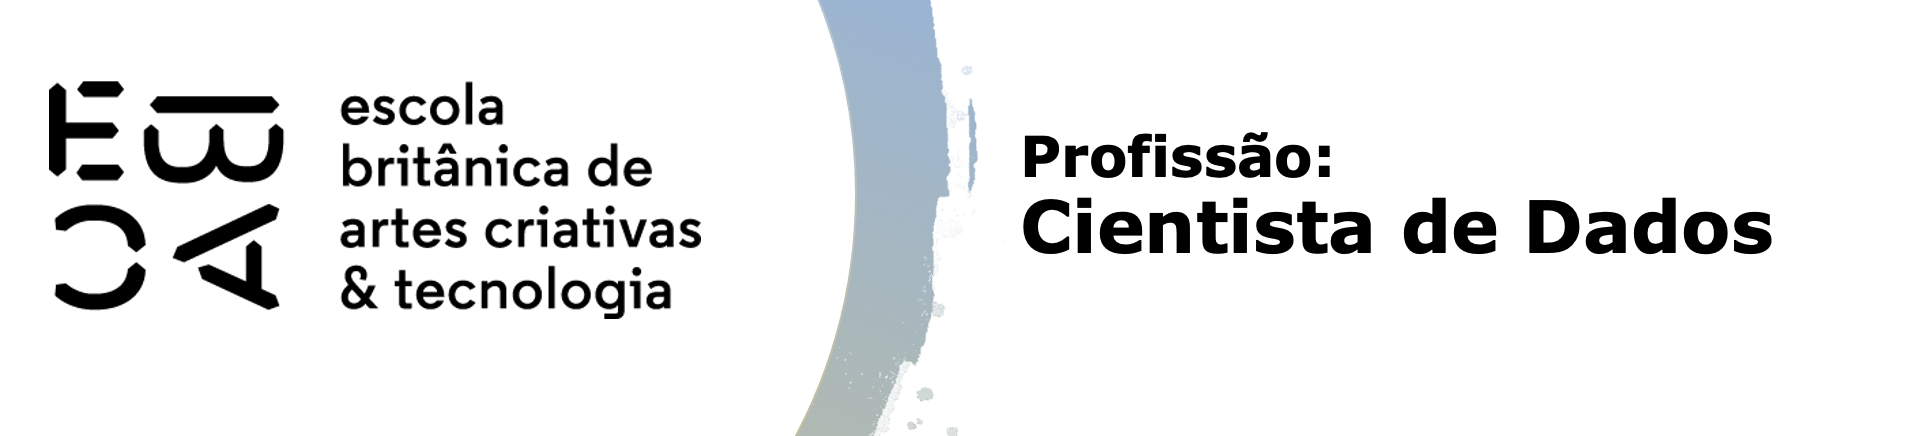

# O problema

- Encontrar grupos de pinguins com padrões biométricos parecidos
- Pinguins típicos de grupos diferentes devem ter diferenças marcantes

# Análise de agrupamentos

Neste módulo vamos falar sobre análise de agrupamentos (*clusters*), com mais foco para o algoritmo *k-means*, o mais popular em ciência de dados para esta finalidade.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

%reload_ext watermark
%watermark -iv -v -p sklearn

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

sklearn: 1.3.0

matplotlib: 3.8.1
pandas    : 2.1.3
seaborn   : 0.13.0



# Aplicação

Vamos aplicar o algoritmo de cluster na base de pinguins.

|Função |Descrição |
|-|-|
|KMeans |é a função do scikitlearn que faz o algoritmo k-means |
| Standard Scaler |É uma função que faz padronização de variáveis (*Scaling*),|



## Carregando os dados
Vamos usar como exemplo a base de pinguins do seaborn. Como muitos algoritmos, o k-means não suporta valore faltantes (missings), então vamos fazer uma substituição pelo valor médio de cada variável quantitativa. O k-means trabalha somente com variáveis quantitativas. É possível utilizar variáveis dummy, mas há formas melhores de se trabalhar com variáveis qualitativas.


In [2]:
penguins = sns.load_dataset('penguins')

In [3]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [4]:
# Há registros missing?
penguins.isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [9]:
# Onde estão os missing?
penguins[penguins.body_mass_g.isna()]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN


In [6]:
# Eliminando os missing
penguins.dropna(subset=['body_mass_g'], inplace=True)

In [7]:
# selecionando apenas variáveis numéricas
penguins_quant = penguins.select_dtypes(include="number")
penguins_quant.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0


## Análise descritiva
Antes de rodar o algoritmo, vamos avaliar uma matriz de gráficos de dispersão (*scatterplot matrix*) para verificar se há algum padrão evidente nos dados.

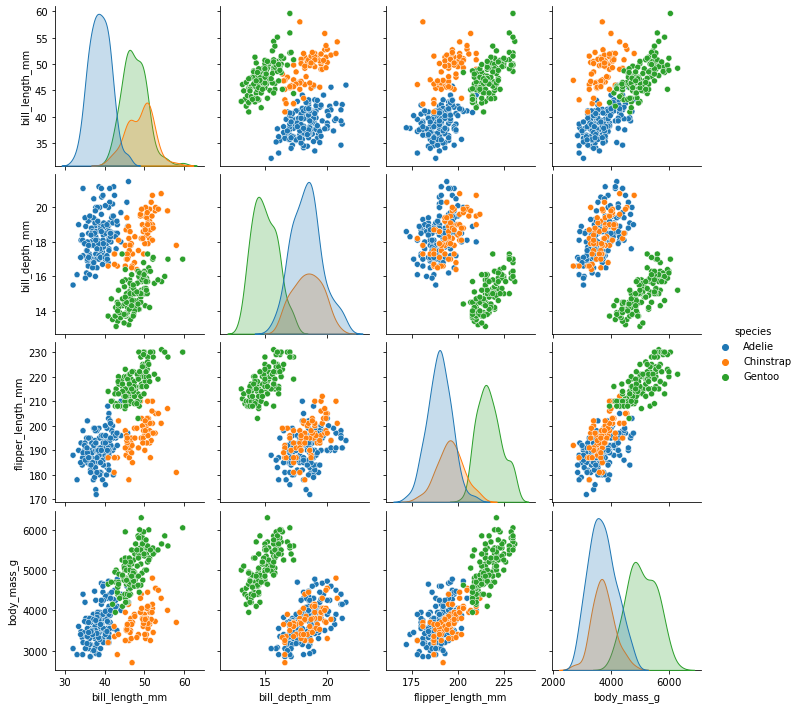

In [9]:
sns.pairplot(penguins, hue='species')

## Rodando o algoritmo
De uma forma bem similar a outros algoritmos de *machine learning*, vamos definir um objeto com a classe KMeans, em seguida vamos aplicar o método fit, indicando a base de dados.

In [10]:
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
kmeans.fit(penguins_quant)

KMeans(max_iter=600, n_clusters=3)

Podemos identificar os grupos com o atribuito ```labels_```. Vamos construir um gráfico de dispersão para ver como esses grupos ficaram.

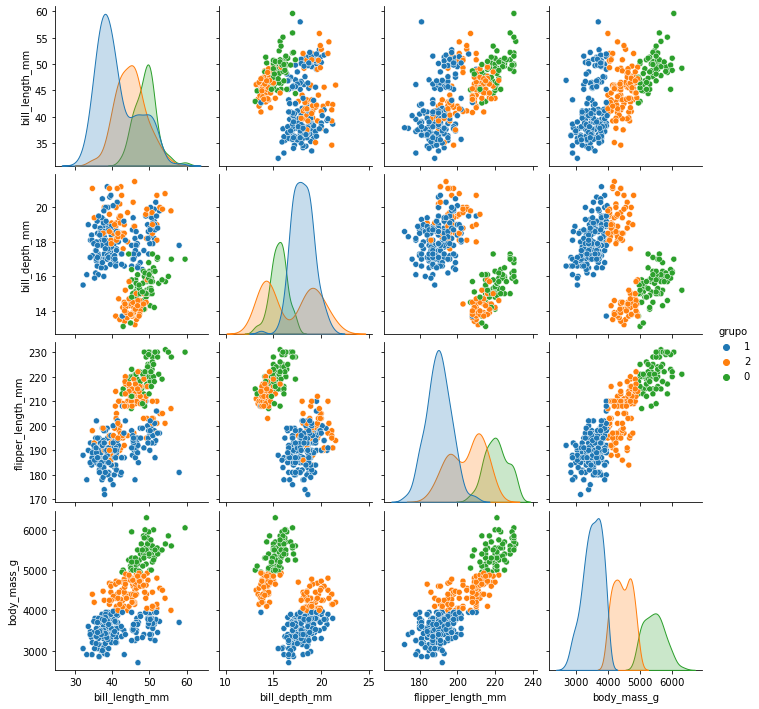

In [13]:
penguins['grupo'] = kmeans.labels_.astype('str')
sns.pairplot(penguins, hue='grupo')

Os grupos ficaram um tanto esuquisitos... os gráficos de baixo estão com um aspecto de "bandeira". O que aconteceu é que o algoritmo utilizou quase que somente a variável ```body_mass```. Por que? 

Bem, repare na escala dessa variável, ela está em gramas e fornece valores muito maiores que as demais variáveis. Faça o exercício de calcular a distâcia entre um par de pinguins, e você vai confirmar que a contribuição da variável ```body_mass``` é muito maior que as demais variáveis.

## Distância

Para fazer o agrupamento, o algoritmo usa uma medida de *dissimilaridade* ou simplesmente distância (o quanto duas observações são diferentes) para agrupar os pinguins. A medida mais comum, a que usaremos, é a distância euclidiana calculada nas variáveis quantitativas entre dois indivíduos (```a``` e ```b```) pode ser escrita como:

$$ d = \sqrt{\sum_{i=1}^{p} (\delta(x_i))^2} $$

com:
- $x_i$ sendo a i-ésima variável
- i indexando as variáveis, valendo 1, 2, ... p
- p é o número de variáveis
- $\delta(x_i) = x_{i, a} - x_{i, b}$ é a diferença da variável $x_i$ entre os indivíduos a e b.

## Variáveis em escalas diferentes
Variáveis com unidades de medida diferentes frequentemente fornecem escalas diferentes, como no caso dos pinguins. Quando calculamos uma distância considerando estas variáveis tão diferentes, estamos realizando uma "ponderação arbitrária".
- **Ponderação** porque estamos dando pesos ou importâncias diferentes para cada variável
- **Arbitrária** porque podemos medir a massa corporal em kilos ou toneladas, sem alterar a informação que a variável traz, mas alterando **arbitrariamete** a importância que ela teria no algoritmo.

## Como resolver o problema de escala?

Ok, como resolvemos isso? 

Uma forma muito popular de abordar este problema é realizar uma alteração de escala padronizada (um *scaling* em inglês) nas variáveis quantitativas. Para qual escala podemos transformar? Se dividirmos cada variável pelo seu desvio padrão, a unidade de medida da variável fica 'adimensional' - ou podemos entender que uma unidade equivale a 1 desvio padrão (vale refletir a respeito). Costuma-se também subtrair a própria média da variável, de modo que ela fique com média=0 e desvio padrão = 1.

Essa padronização pode ser escrita assim:

$$ x_{pad} = \frac{x - \bar{x}}{desv\_pad(x)} $$

A função ```StandardScaler``` faz isso de forma bem prática.

In [14]:
padronizador = StandardScaler()
penguin_padronizado = padronizador.fit_transform(penguins_quant)


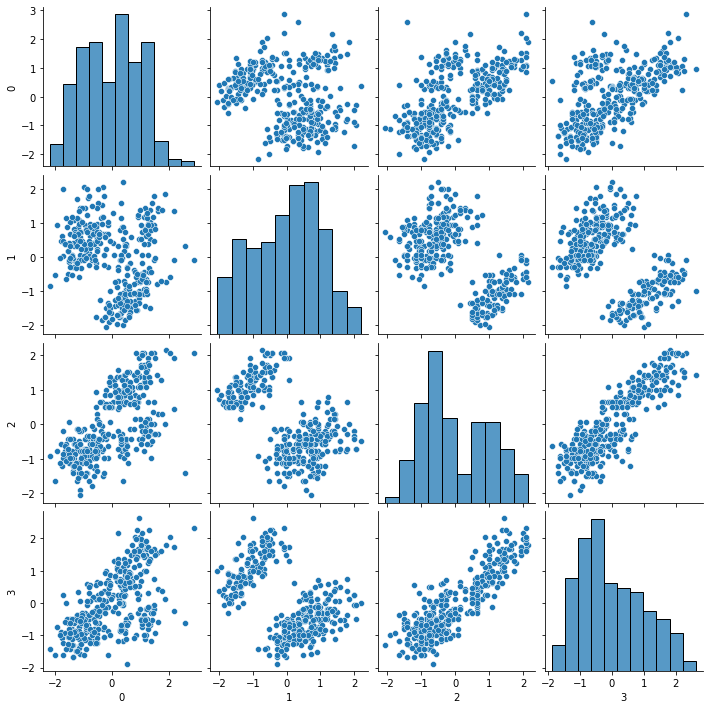

In [16]:
sns.pairplot(pd.DataFrame(penguin_padronizado))

In [17]:
kmeans.fit(penguin_padronizado)

KMeans(max_iter=600, n_clusters=3)

Vamos ver agora como os grupos ficaram:

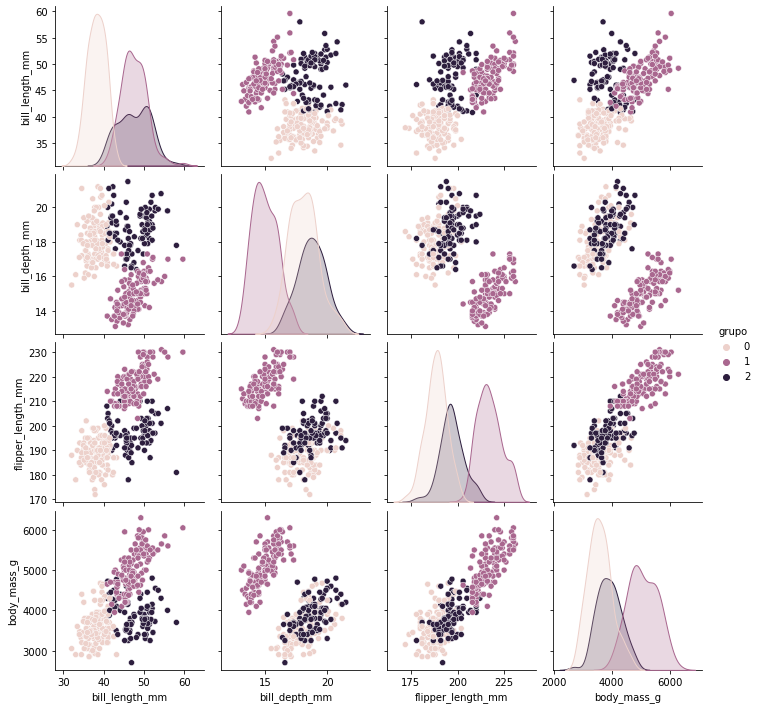

In [18]:
penguins['grupo'] = kmeans.labels_
sns.pairplot(penguins, hue='grupo')

Parece fazer bem mais sentido esse agrupamento. Ele parece considerar igualmente todas as variáveis. Vamos checar abaixo como fica a mesma análise se realçarmos no ```hue``` as espécies de pinguim.

/Users/juka42/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


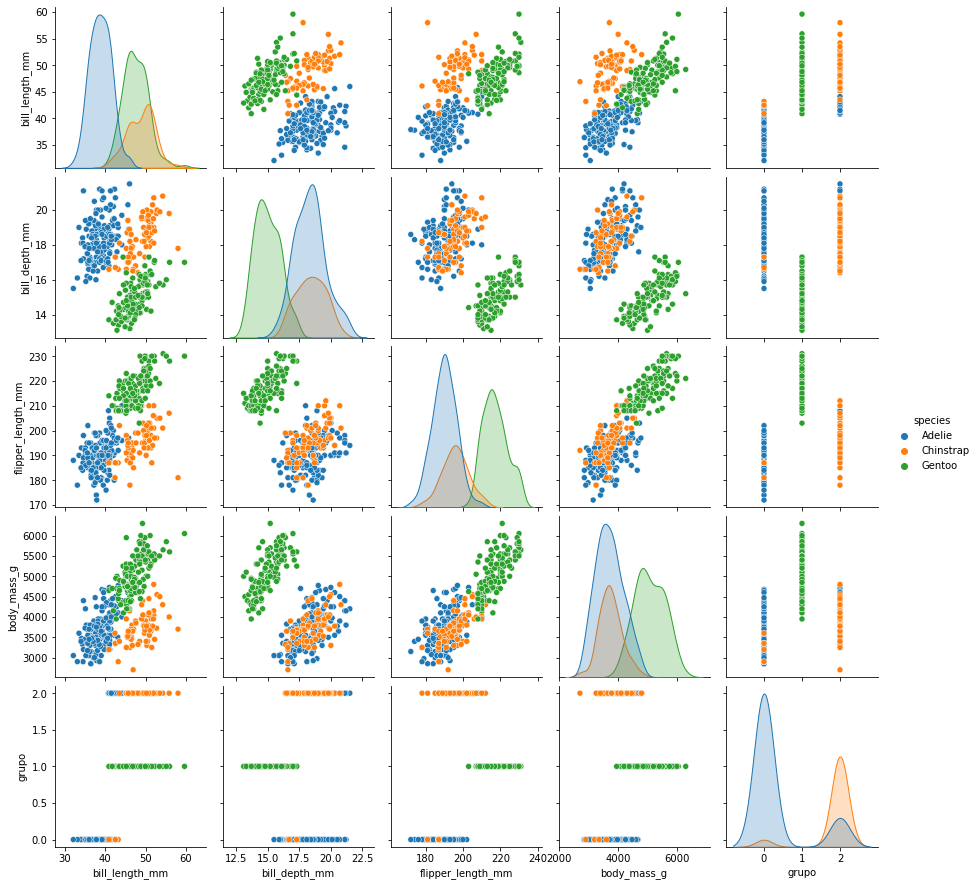

In [19]:
penguins['grupo'] = kmeans.labels_
sns.pairplot(penguins, hue='species')

In [20]:
pd.crosstab(penguins['species'], penguins['grupo'])

grupo,0,1,2
species,,,
Adelie,127,0,24
Chinstrap,5,0,63
Gentoo,0,123,0


Os grupos têm uma concordância boa com as espécies! Mas não se esqueça: não estamos tentando 'acertar' as espécies, mas sim encontrar padrões entre as variáveis biométricas dos pinguins e dividi-los em grupos de pinguins *semelhantes dentro do grupo e diferentes entre grupos*. A concordância é uma curiosa e feliz coincidência.